In [1]:
from __future__ import print_function 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import datetime as dt

mpl.rcParams['savefig.dpi'] = 100 
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 40})

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

import matplotlib.dates as mdates

In [2]:
import geojson
from shapely.geometry import mapping, shape

In [3]:
taxi_zones = geojson.load(open('taxi_zones.geojson'))

In [4]:
z_hoods = geojson.load(open('ZillowNeighborhoods-NY.geojson'))

In [5]:
z_hoods['features'][0]['properties']

{u'City': u'Town of Islip',
 u'County': u'Suffolk',
 u'Name': u'Bohemia',
 u'RegionID': u'3736',
 u'State': u'NY'}

In [6]:
list(z_hoods['features'][0].keys())

['geometry', u'type', 'properties']

In [7]:
len(z_hoods['features'])

579

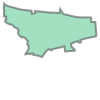

In [10]:
z0 = shape(z_hoods['features'][0]['geometry'])
z0

In [11]:
class Neighborhood(object):
    def __init__(self, feature):
        self.properties = feature['properties']
        self.geometry = feature['geometry']
        self.shape = shape(feature['geometry'])

z_hoods_shapes = [Neighborhood(f)
                  for f in z_hoods['features']
                  if f['properties']['City'] == 'New York']
taxi_zones_shapes = [Neighborhood(f) for f in taxi_zones['features']]

In [12]:
print(len(z_hoods_shapes))
print(len(taxi_zones_shapes))

278
263


In [13]:
def plot(gjs, **kwargs):
    test_lon, test_lat = -73.955, 40.727
    for feature in gjs:
        x, y = feature
        plt.plot(x,y,**kwargs)

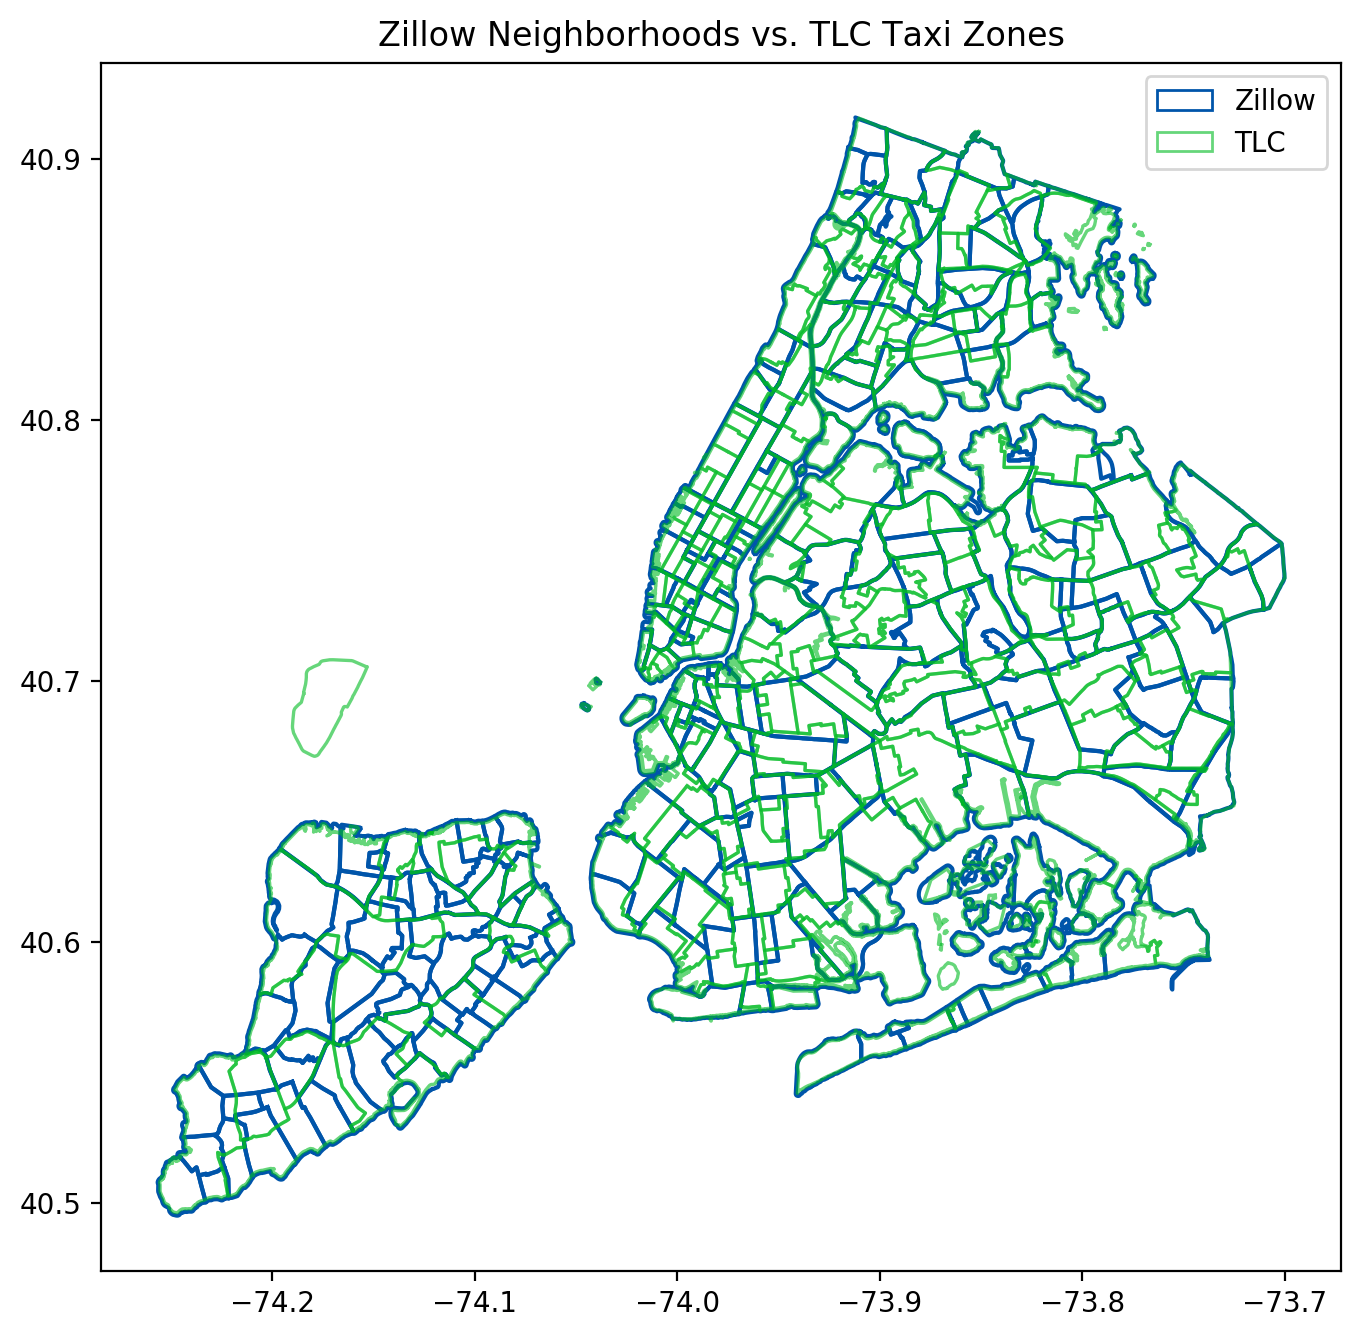

In [16]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

z_col = '#0055aaff'
t_col = '#00bb2299'

z_patch = mpatches.Patch(facecolor='white', edgecolor=z_col, label='Zillow')
t_patch = mpatches.Patch(facecolor='white', edgecolor=t_col, label='TLC')

def plot(shape, **kwargs):
    if shape.type == 'MultiPolygon':
        for g in shape.geoms:
            plot(g, **kwargs)
    else:
        x, y = shape.exterior.xy
        plt.plot(x ,y, **kwargs)

plt.figure(figsize=(8,8))
plt.title('Zillow Neighborhoods vs. TLC Taxi Zones')
[plot(z.shape, color=z_col, linewidth=1.5) for z in z_hoods_shapes]
[plot(t.shape, color=t_col, linewidth=1.2) for t in taxi_zones_shapes]
test_lon, test_lat = -73.955, 40.727
plt.legend(handles=[z_patch, t_patch], loc='best')
plt.show()

In [70]:
taxi_zones_shapes[3].shape.intersection(z_hoods_shapes[3].shape).area

0.0

# Calculate Neighborhood Adjacency

In [38]:
# Create an adjacency matrix.
from shapely.affinity import translate
z_edges = {}
for za in z_hoods_shapes:
    ida = int(za.properties['RegionID'])
    print(za.properties['County'], za.properties['Name'])
    cax, cay = za.shape.centroid.xy
    for zb in z_hoods_shapes:
        if za.properties['County'] != zb.properties['County']:
            continue
        idb = int(zb.properties['RegionID'])
        cbx, cby = zb.shape.centroid.xy
        dx = cax[0] - cbx[0]
        dy = cay[0] - cby[0]
        intersect = za.shape.intersection(translate(zb.shape, 0.01 * dx, 0.01 * dy))
        if intersect.area > 0:
            k1 = (ida, idb)
            k2 = (idb, ida)
            if k1 in z_edges or k2 in z_edges:
                pass
            else:
                z_edges[k1] = True
z_edges = list(z_edges.keys())

Queens Rego Park
Queens Belle Harbor
New York Roosevelt Island
Queens Howard Beach
Queens Breezy Point
Queens Neponsit
Queens East Elmhurst
Bronx West Farms
Queens Cambria Heights
Queens Fresh Meadows
Queens Maspeth
Kings Fort Hamilton
Richmond Bay Terrace
Queens Far Rockaway
Queens Hollis
Queens Jamaica
Queens South Ozone Park
New York Ellis Island
Queens Bayside
Queens La Guardia Airport
Queens Woodhaven
Queens Arverne
Queens Broad Channel
Queens Flushing
Queens Oakland Gardens
Queens Ozone Park
Queens Fort Tilden
Queens Malba
Queens Briarwood
Queens College Point
Queens Corona
Queens Pomonok
Queens Jamaica Estates
Queens Rockaway Park
Queens Roxbury
Queens Rockaway Beach
Queens Glen Oaks
Richmond Arrochar
Queens Kew Gardens Hills
Kings Bensonhurst
Kings Bath Beach
Kings Bay Ridge
Bronx Clason Point
Richmond Clifton
Kings East Flatbush
Kings Bergen Beach
Kings Borough Park
Kings Brighton Beach
Kings Brownsville
Kings Canarsie
Kings East New York
Richmond Elm Park
Kings Dyker Heights


In [39]:
z_edges[:10]

[(275247, 274285),
 (4819, 18131),
 (270902, 403222),
 (193587, 193587),
 (49994, 26352),
 (270828, 270828),
 (270852, 270852),
 (49994, 276345),
 (195511, 197623),
 (194737, 270914)]

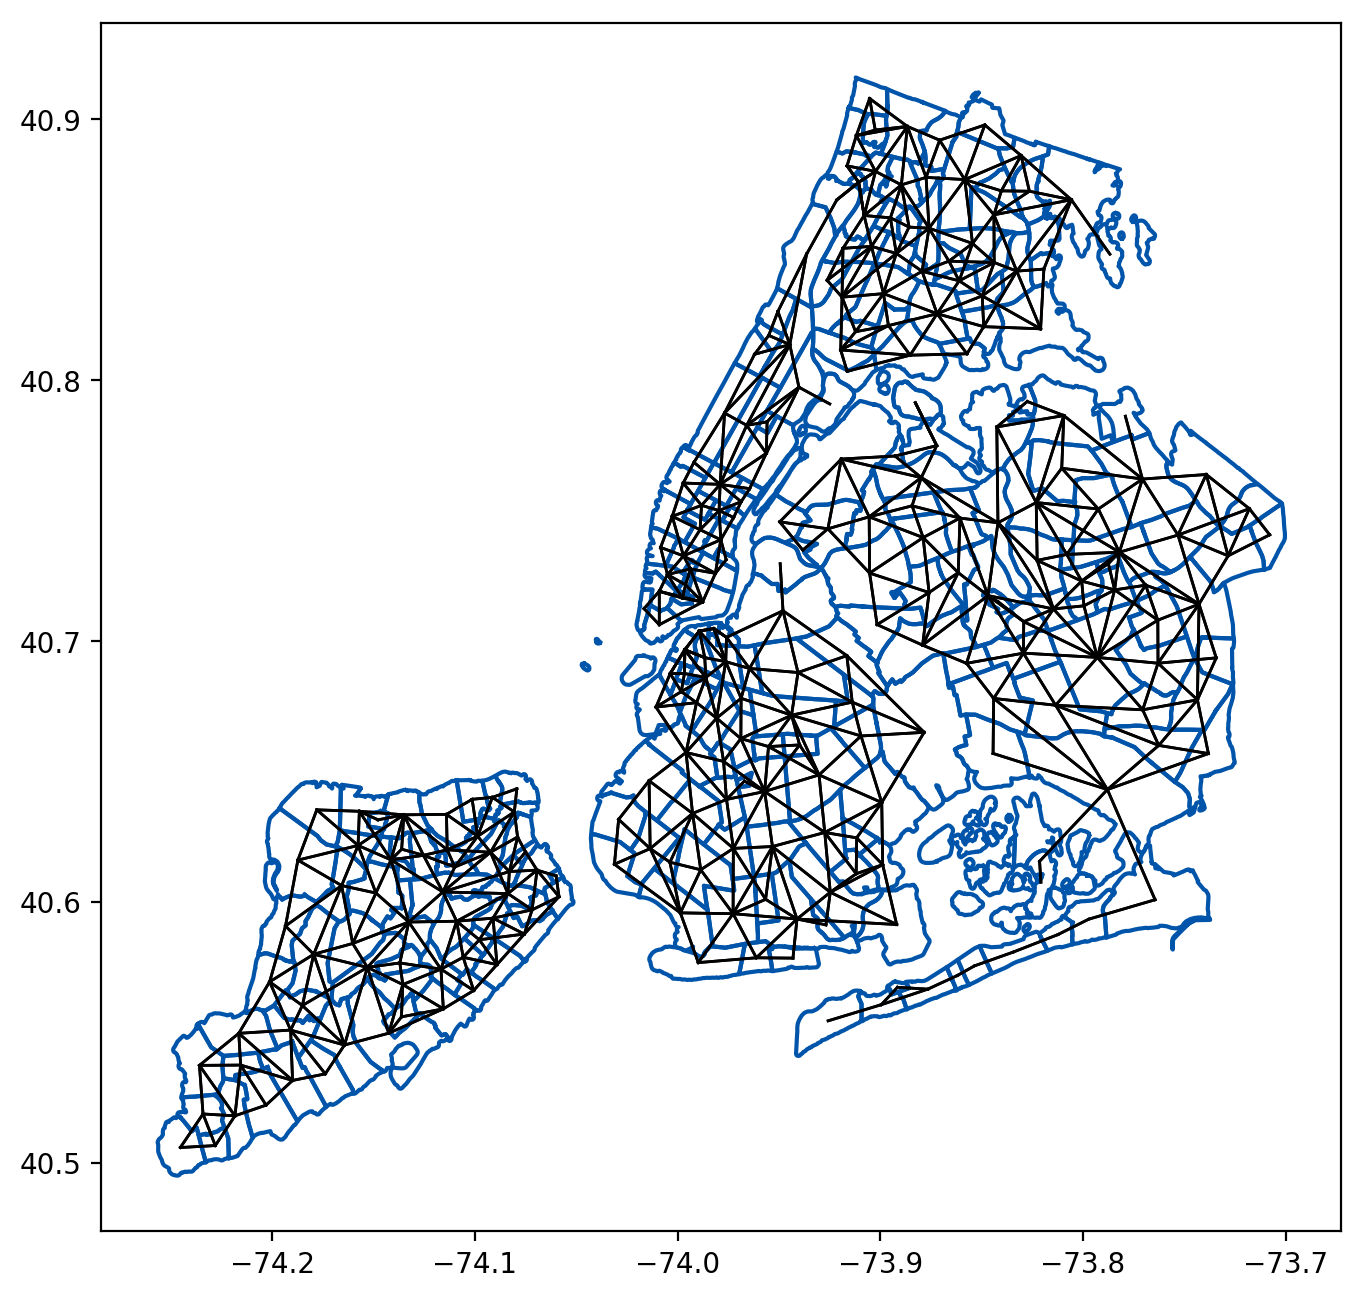

In [47]:
len(z_edges)
zset = set(z_edges)
plt.figure(figsize=(8,8))
[plot(z.shape, color=z_col, linewidth=1.5) for z in z_hoods_shapes]
for za in z_hoods_shapes:
    ida = int(za.properties['RegionID'])
    cax, cay = za.shape.centroid.xy
    for zb in z_hoods_shapes:
        idb = int(zb.properties['RegionID'])
        cbx, cby = zb.shape.centroid.xy
        k1 = (ida, idb)
        k2 = (idb, ida)
        if k1 in zset or k2 in zset:
            plt.plot([cax[0], cbx[0]], [cay[0], cby[0]], color='k', linewidth=1)
    
plt.show()

In [49]:
import json
json.dump(z_edges, open('ZillowNeighborhoods_RegionID_edges.json', 'w'))

## For Taxis

In [50]:
taxi_zones_shapes[3].properties

{u'LocationID': 4,
 u'OBJECTID': 4,
 u'Shape_Area': 0.000111871946192,
 u'Shape_Leng': 0.0435665270921,
 u'borough': u'Manhattan',
 u'zone': u'Alphabet City'}

In [53]:
# Create an adjacency matrix.
t_edges = {}
num_neighbors = []
for za in taxi_zones_shapes:
    ida = int(za.properties['LocationID'])
    cax, cay = za.shape.centroid.xy
    nb = 0
    for zb in taxi_zones_shapes:
        if za.properties['borough'] != zb.properties['borough']:
            continue
        idb = int(zb.properties['LocationID'])
        cbx, cby = zb.shape.centroid.xy
        dx = cax[0] - cbx[0]
        dy = cay[0] - cby[0]
        intersect = za.shape.intersection(translate(zb.shape, 0.01 * dx, 0.01 * dy))
        if intersect.area > 0:
            nb += 1
            k1 = (ida, idb)
            k2 = (idb, ida)
            if k1 in t_edges or k2 in t_edges:
                pass
            else:
                t_edges[k1] = True
        num_neighbors.append(nb)
t_edges = list(t_edges.keys())

In [54]:
import pandas as pd
pd.DataFrame(num_neighbors).describe()

,0
count,15493.000000
mean,2.973085
std,2.321302
min,0.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,14.000000


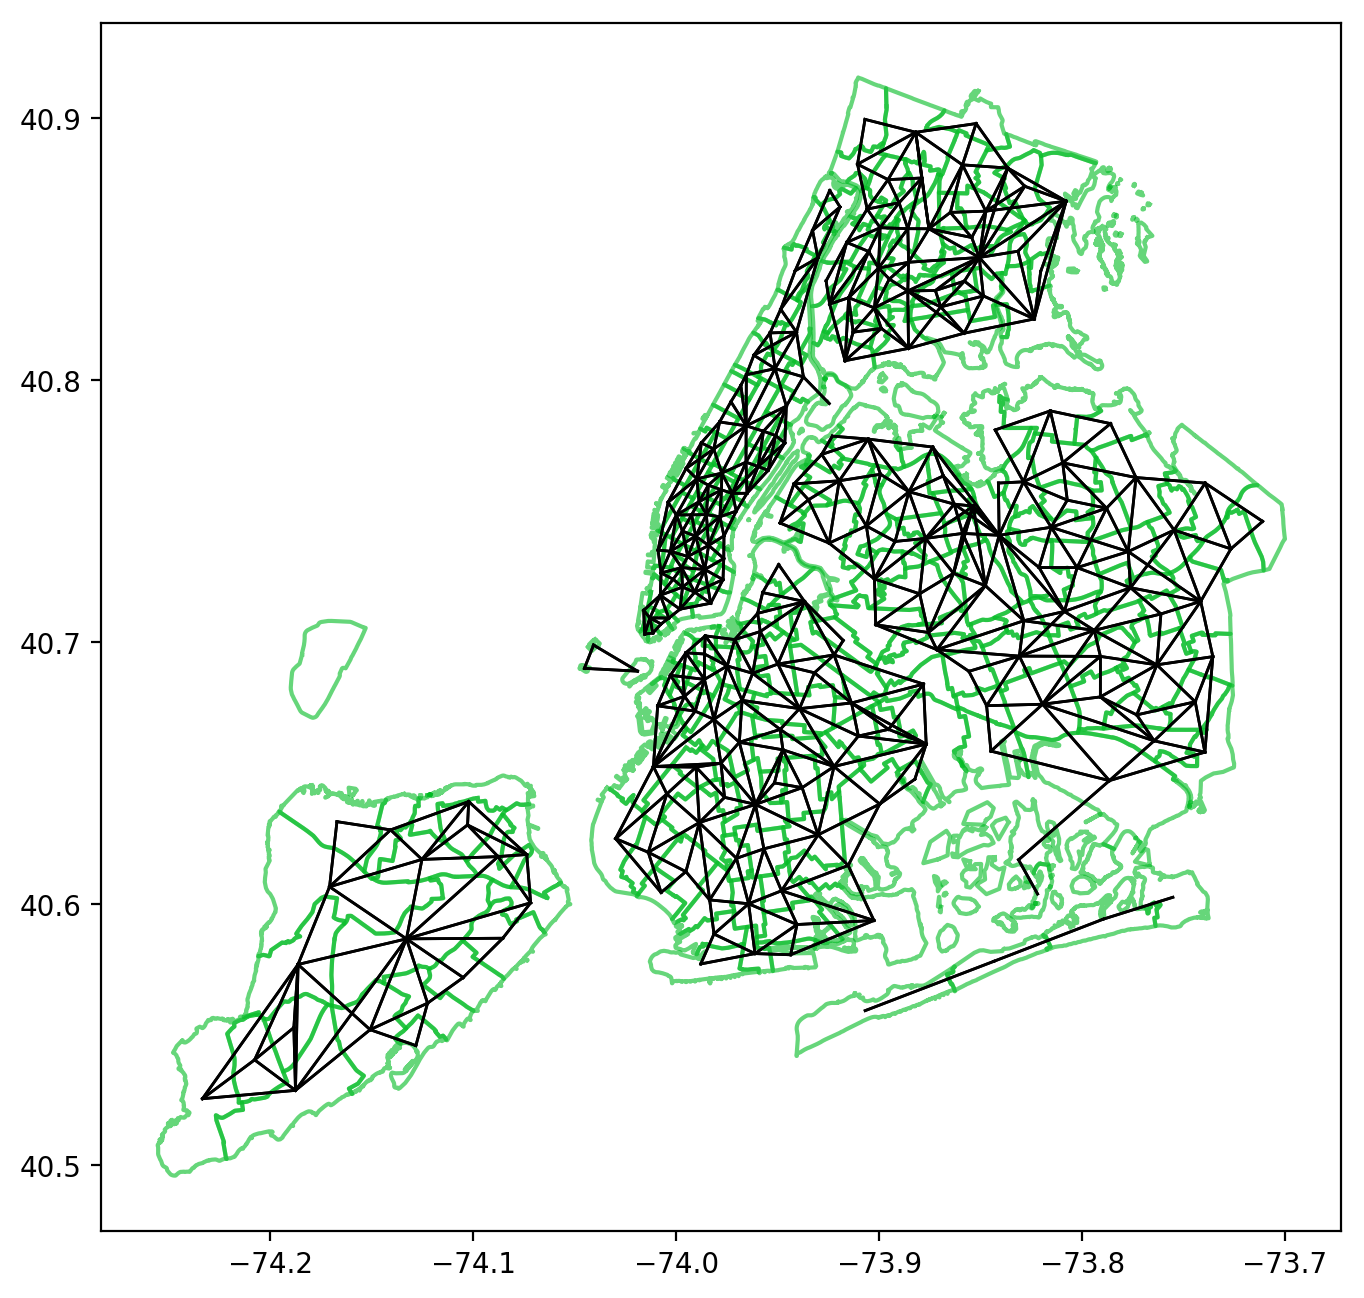

In [56]:
tset = set(t_edges)
plt.figure(figsize=(8,8))
[plot(z.shape, color=t_col, linewidth=1.5) for z in taxi_zones_shapes]
for za in taxi_zones_shapes:
    ida = int(za.properties['LocationID'])
    cax, cay = za.shape.centroid.xy
    for zb in taxi_zones_shapes:
        idb = int(zb.properties['LocationID'])
        cbx, cby = zb.shape.centroid.xy
        k1 = (ida, idb)
        k2 = (idb, ida)
        if k1 in tset or k2 in tset:
            plt.plot([cax[0], cbx[0]], [cay[0], cby[0]], color='k', linewidth=1)
    
plt.show()

In [57]:
print(len(t_edges))
json.dump(t_edges, open('taxi_zones_LocationID_edges.json', 'w'))

895
